<a href="https://colab.research.google.com/github/SeunghyeChae/tmdhey/blob/main/ai_spark/DETR2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Repository clone

In [ ]:
git clone https://github.com/facebookresearch/detr.git

## Install pycocotools

COCO dataset에 evaluation을 하기 위한 툴

In [5]:
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

# pip install git+https://github.com/cocodataset/panopticapi.git

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-_k9mgabm
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-_k9mgabm
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=263951 sha256=c78e7a0cb82e666e1c61c2ae5bb4378f3686d1e50f2cd855b3845c850bfc3685
  Stored in directory: /tmp/pip-ephem-wheel-cache-2z9ruwr4/wheels/e2/6b/1d/344ac773c7495ea0b85eb228bc66daec7400a143a92d36b7b1
Successfully built pycocotools
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0.4
    Uninstalling pycocotools-2.0.4:
      Successfully uninstalled pycocotools-2.0.4


In [10]:
# !python -m torch.distributed.launch --nproc_per_node=8 --use_env main.py --coco_path /path/to/coco 

In [11]:
# !python main.py --batch_size 2 --no_aux_loss --eval --resume https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth --coco_path /path/to/coco

# ~  ~

In [12]:
import requests
import matplotlib.pyplot as plt
import time

from PIL import Image
import requests
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import torch
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T
torch.set_grad_enabled(False);

In [14]:
CLASSES = [
           'pig','cow'
]

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

# standard PyTorch mean-std input image normalization
# 1. 이미지의 높이와 너비 중 작은 사이즈가 800으로 고정됩니다.
# 2. Tensor에 맞게끔 [w,h] format이 [h,w] format으로 변합니다.
# 3. dataset의 mean, std를 이용해 정규화가 진행됩니다. (값이 -3과 3사이에 대부분 분포합니다)
transform= T.Compose([
    T.Resize(800), # * 이유.
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # dataset을 확인하면 된다
])

# output bounding box 후처리
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

In [17]:
class DETRdemo(nn.Module):
    """
    DETR의 demo버전은 아래와 같은 요소가 논문에 쓰인 모델과 다릅니다.
    * learned positional encoding(원래 sine 사용)
    * positional encoding은 input에 pass(원래 attention에 pass)
    * fc bbox predictor (원래 MLP)
    
    성능은 약 ~40 AP정도 나오며, 1 batch size만 지원한다.
    """
    
    def __init__(self, num_classes, hidden_dim=256, nheads=8,
                num_encoder_layers=6, num_decoder_layers=6):
        
        # nn.Module을 initialize 해줍니다.
        super().__init__()
        
        
        # Resnet-50 backbone 모델 할당
        self.backbone = resnet50()
        # backbone은 feature map 생성에만 쓰인다(fully connecter layer는 필요 없음).
        del self.backbone.fc 
        
        
        # resnet50에서 fc-layer를 제거하고 나면 마지막 output의 차원은 (None, 7, 7, 2048) 입니다. (input이 224 x 224일 때)
        # 그렇기에, input channel : 2048, output channel 256(hidden_dim), kernel size 1인 
        # conv layer를 추가해줌으로써 channel의 차원을 256로 낮춰줍니다.
        # 여기서 256차원은 transformer의 input tokens의 차원이기도 합니다(token의 length는 가변적입니다).
        self.conv = nn.Conv2d(2048, hidden_dim, 1)
        
        # pytorch 내 기본 transformer 추가
        self.transformer = nn.Transformer(hidden_dim, nheads, 
                                        num_encoder_layers, num_decoder_layers)
        
        # 예측을 위한 prediction heads에 background detection을 위한 1 extra class를 추가해줍니다.
        # 단, original DETR에서 linear_bbox는 3-layer MLP을 사용합니다.
        self.linear_class = nn.Linear(hidden_dim, num_classes + 1)
        self.linear_bbox = nn.Linear(hidden_dim, 4)
        
        # output positional encodings(object queries) 추가 
        # 100 x 256 차원의 가우시안분포(default)
        # 이 때, 100은 transformer decoder의 sequence입니다. 
        self.query_pos = nn.Parameter(torch.rand(100, hidden_dim))
        
        # spatial positional embeddings
        # 역시, original DETR에서는 sine positional encodings을 사용합니다(demo 버전에선 학습용).
        # 이 때 demo 버전에서는 input의 size를 800 x n 으로 맞춥니다(800<=n<=1600).
        # backbone인 resnet을 통과시키고 나면 size가 32분의 1로 줄기 때문에 
        # feature map의 width(또는 height)는 50을 넘지 않습니다. 
        # forward 단계에서 각 feature map의 size에 맞게 slicing해 사용하게 됩니다. 
        # hidden dimension의 
        
        self.row_embed = nn.Parameter(torch.rand(50, hidden_dim//2))
        self.col_embed = nn.Parameter(torch.rand(50, hidden_dim//2))
        
    def forward(self, inputs):
        
        # Resnet-50에서 average pooling layer 전까지 순전파시킵니다. 
        # resnet은 최초의 convolution - batch norm - relu - maxpool을 거친 후, 
        # conv-batch norm을 주 구성요소로 하는 Bottleneck layer을 굉장히 많이 통과시킵니다.
        x = self.backbone.conv1(inputs)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)
        
        x = self.backbone.layer1(x) # layer1은 downsampling을 진행하지 않습니다.
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)
        # avg-layer는 사용하지 않습니다.
        # 여기서 tensor x의 shape은 [None, 2048, input_height//32, input_width//32] 입니다.
        
        # 2048차원의 channel을 가진 feature map(planes)을 256차원의 channle의 feature map으로 축소시킵니다.
        h = self.conv(x)
        # 여기서 tensor h의 shape은 [None, 256, input_height//32, input_width//32] 입니다.
        
        
        # positional encoding을 구성합니다.
        H, W = h.shape[-2:] # backbone + conv를 통해 생성된 feature map의 높이와 너비입니다. 
        
        # 아래의 positional embeddings을 transformer의 input tokens(1d flattened feature map, 즉 tensor h)와 concat함으로써
        # 위치 정보가 없는 input tokens에 위치 정보가 담기게 됩니다.
        
        # 높이, 너비 각각 feature map의 size에 해당하는 positional embeddings을 slicing합니다.
        # column 정보를 담은 positional embeddings (H x W x 128)과 --> H는 그저 차원을 맞추기 위함입니다.
        # row 정보를 담은 positional embeddings (H x W x 128)를 생성한 후 --> W는 그저 차원을 맞추기 위함입니다.
        # concat을 시켜 transformer의 input tokens의 차원인 256과 일치시킨 후 
        # (H x W x 256)의 2d positional embeddings을 (HW x 256)의 1d positional embeddings으로 flatten 해줍니다.
        
        # 이는 2d feature map이 transformer의 input tokens으로 쓰이기 전에 1d feature sequence로 flatten 하는 것과 일치합니다.
        pos=torch.cat([
            self.col_embed[:W].unsqueeze(0).repeat(H, 1, 1),
            self.row_embed[:H].unsqueeze(1).repeat(1, W, 1),
        ], dim=-1).flatten(0, 1).unsqueeze(1)

        # transformer를 순전파시킵니다.
        # 1d feature sequence와 positional embeddings가 concat되어 transformer의 input tokens으로 쓰이고, 
        # object queries의 길이에 해당하는 output token을 반환합니다.  
        h = self.transformer(pos+0.1*h.flatten(2).permute(2, 0, 1),
                            self.query_pos.unsqueeze(1)).transpose(0,1)
        
        # 최종적으로, transformer output을 class label과 bounding boxes로 사영시킵니다.
        # 결과의 차원은 (1, len of object queries, # of classes (or 4 in bboxes))입니다. 
        return {'pred_logits': self.linear_class(h),
                'pred_boxes': self.linear_bbox(h).sigmoid()}

In [18]:
# Import model of pre-trained DETR

detr = DETRdemo(num_classes=91)
state_dict = torch.hub.load_state_dict_from_url(
    url='https://dl.fbaipublicfiles.com/detr/detr_demo-da2a99e9.pth',
    map_location='cpu', check_hash=True)
detr.load_state_dict(state_dict)
detr.eval();

Downloading: "https://dl.fbaipublicfiles.com/detr/detr_demo-da2a99e9.pth" to /root/.cache/torch/hub/checkpoints/detr_demo-da2a99e9.pth


  0%|          | 0.00/79.3M [00:00<?, ?B/s]

In [34]:
def detect(im, model, transform):
    
    # input image를 정규화해줍니다. (batch-size : 1)
    img = transform(im).unsqueeze(0)
    
    # demo의 경우 aspect ratio를 0.5와 2사이만 지원합니다.
    # 이 범위 밖의 이미지를 사용하고 싶다면 maximum size을 1333이하로 rescaling해야 합니다.
    assert img.shape[-2] <= 1600 and img.shape[-1] <= 1600
    
    # model을 통과시킵니다. 
    outputs = model(img)
    
    # 70 % 이상의 정확도를 가진 예측만 남깁니다.
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > 0.7
    
    # 0과 1사이의 boxes 값을 image scale로 확대합니다.
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)
    return probas[keep], bboxes_scaled

#visualize
def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), COLORS * 100):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        # text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        # ax.text(xmin, ymin, text, fontsize=15,
        #         bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [35]:
# url = 'https://news.imaeil.com/inc/photos/2020/11/02/2020110216374231552_l.jpg'
# im = Image.open(requests.get(url, stream=True).raw)
im = Image. open ('/content/drive/MyDrive/Innopolis_spark/글쎄~ㅋㅋ/sample_data/돼지/img/livestock_pig_bbox_000001.jpg')
start = time.time()

#Detect
scores, boxes = detect(im, detr, transform)

print("Inference time :", round(time.time()-start, 3), 'sec')

Inference time : 0.846 sec


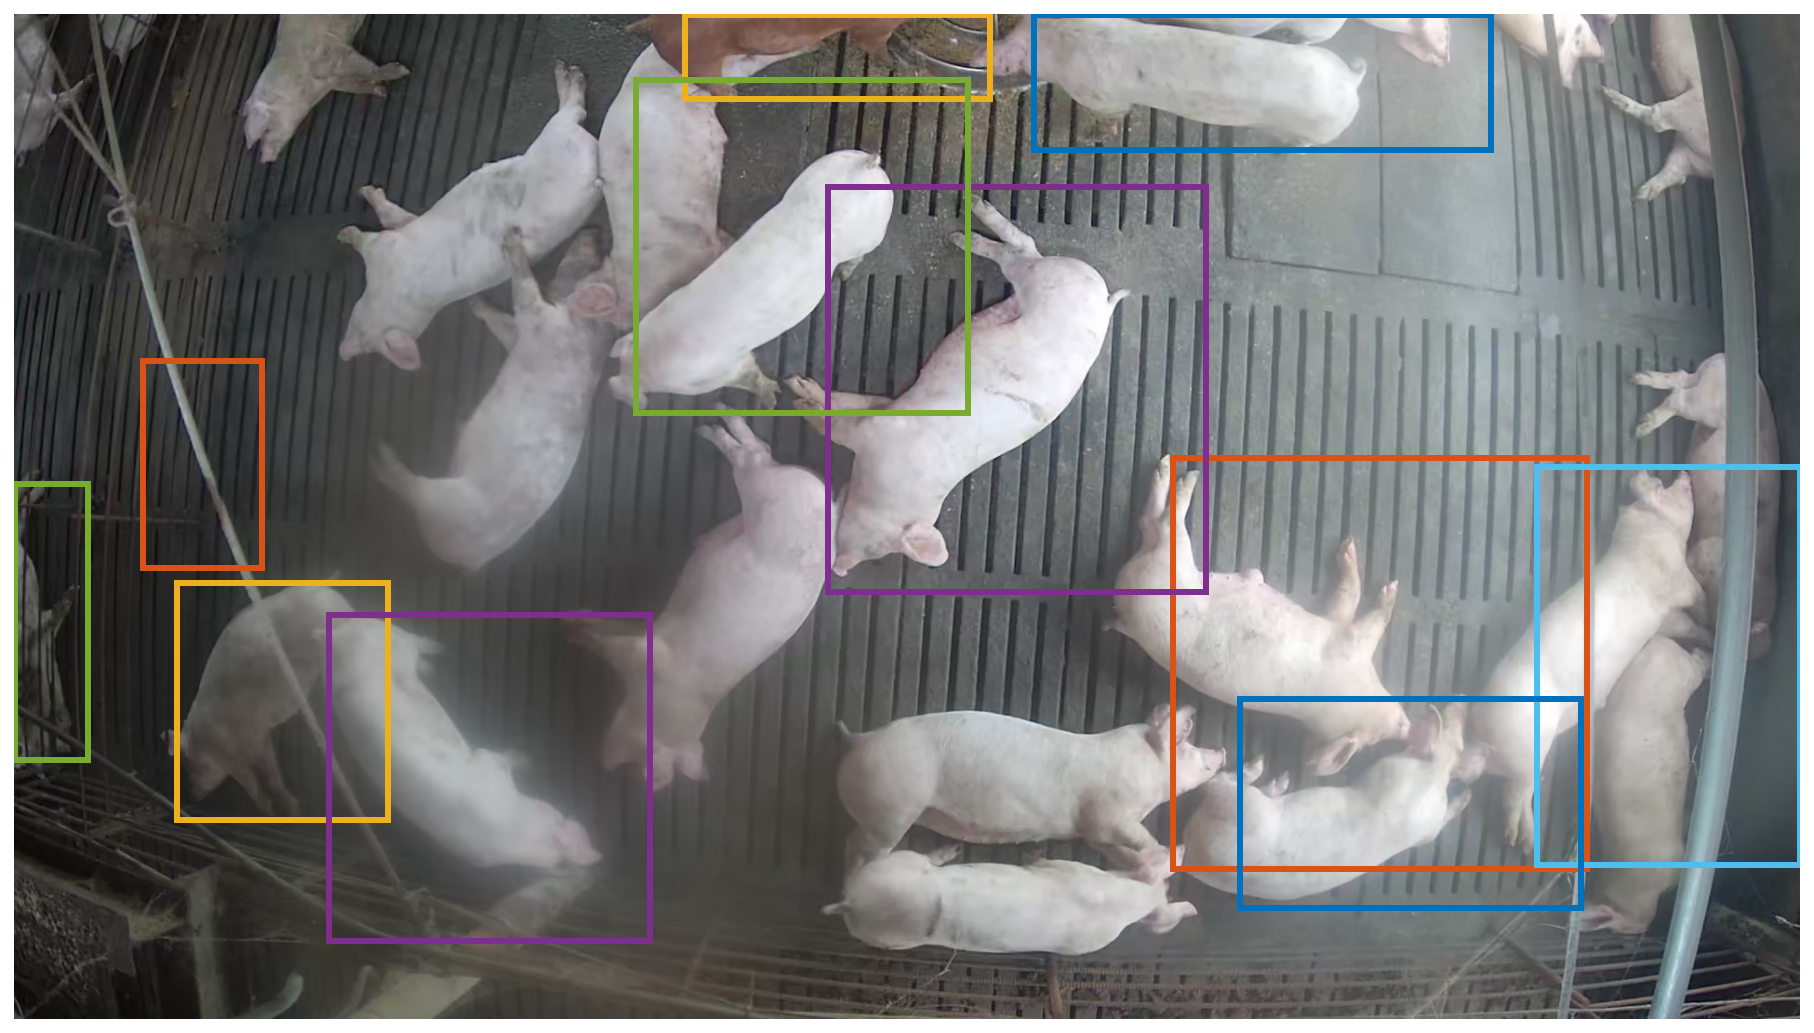

In [36]:
plot_results(im, scores, boxes)